In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate

from astropy.io import fits, ascii
from astropy.table import Table,join
from astropy.table import vstack as vstack_table

from lvmdap.dap_tools import list_columns,read_DAP_file,map_plot_DAP
from matplotlib import use as mpl_use
#mpl_use('Agg')
import sys
org_stdout = sys.stdout # Save a reference to the original standard output

import math
from IPython.display import display, HTML
%matplotlib inline
from matplotlib import rcParams as rc
rc.update({'font.size': 19,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 19,\
           'ytick.labelsize' : 19,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


In [2]:
import sys, os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1



import time
from astropy.io.fits.column import _parse_tdim
import numpy as np
import argparse
from copy import deepcopy as copy
from pprint import pprint

# pyFIT3D dependencies
from pyFIT3D.common.io import clean_preview_results_files, print_time, read_spectra

# 18.11.2023
# So far we were ysing the auto_ssp_tools from pyFIT3D
# We will attempt to modify them
#from pyFIT3D.common.auto_ssp_tools import auto_ssp_elines_single_main
from lvmdap.modelling.auto_rsp_tools import auto_rsp_elines_single_main

from pyFIT3D.common.auto_ssp_tools import load_rss, dump_rss_output
from pyFIT3D.common.io import clean_preview_results_files, print_time, read_spectra

from pyFIT3D.common.gas_tools import detect_create_ConfigEmissionModel
from pyFIT3D.common.io import create_ConfigAutoSSP_from_lists
from pyFIT3D.common.io import create_emission_lines_file_from_list
from pyFIT3D.common.io import create_emission_lines_mask_file_from_list
#from pyFIT3D.common.tools import read_coeffs_CS

from lvmdap.modelling.synthesis import StellarSynthesis
from lvmdap.modelling.auto_rsp_tools import ConfigAutoSSP
from lvmdap.modelling.auto_rsp_tools import model_rsp_elines_single_main

from lvmdap.dap_tools import load_LVM_rss, read_PT, rsp_print_header, plot_spec, read_rsp
from lvmdap.dap_tools import plot_spectra, read_coeffs_RSP, read_elines_RSP, read_tab_EL
from lvmdap.dap_tools import find_redshift_spec
from lvmdap.flux_elines_tools import flux_elines_RSS_EW

from scipy.ndimage import gaussian_filter1d,median_filter

from astropy.table import Table
from astropy.table import join as tab_join
from astropy.table import vstack as vstack_table
from astropy.io import fits, ascii

import yaml
import re
from collections import Counter

from lvmdap.dap_tools import list_columns,read_DAP_file,map_plot_DAP

#
# Just for tests
#
# import matplotlib.pyplot as plt


CWD = os.path.abspath(".")
EXT_CHOICES = ["CCM", "CAL"]
EXT_CURVE = EXT_CHOICES[0]
EXT_RV = 3.1
N_MC = 20


In [3]:
# Number of stars in the model
n_st=10
n_sim=100
f_scale=1
label='sim_5'
config_yaml='lvm-dap_100.yaml'
fileID='00006109'
lvmCFrame=f'data/lvmCFrame-{fileID}.fits'
hdu_org=fits.open(lvmCFrame)
ref_file=f"output_ofelia_new/dap-rsp30-sn20-{fileID}.output.fits.gz"
hdu=fits.open(ref_file)
dap_file=f"output_ofelia_new/dap-rsp30-sn20-{fileID}.dap.fits.gz"
tab_DAP=read_DAP_file(dap_file,verbose=True)

---- ALL Table Columns -----
-------------------------------
|        PT                   |
-------------------------------
id        dec       fiberid   
ra        mask      exposure  
----------------------------------
|        RSP                      |
----------------------------------
id             alpha          flux_st        Fe_MW          
MIN_CHISQ      e_alpha        redshift_st    e_Fe_MW        
Teff           Av_st          med_flux_st    alpha_MW       
e_Teff         e_Av_st        e_med_flux_st  e_alpha_MW     
Log_g          z_st           Teff_MW        vel_st         
e_Log_g        e_z_st         e_Teff_MW      log_ML         
Fe             disp_st        Log_g_MW       log_Mass       
e_Fe           e_disp_st      e_Log_g_MW                    
----------------------------------
|        PE_ord                   |
----------------------------------
id                 e_disp_pe_4861.32  e_flux_pe_6548.08  e_vel_pe_6716.39   
flux_pe_3727.4     vel_pe_4861.32   

In [4]:

hdu_org['FLUX'].data=hdu_org['FLUX'].data[0:n_sim,:]
hdu_org['ERROR'].data=hdu_org['ERROR'].data[0:n_sim,:]
hdu_org['MASK'].data=hdu_org['MASK'].data[0:n_sim,:]
hdu_org['FWHM'].data=hdu_org['FWHM'].data[0:n_sim,:]
hdu_org['SKY'].data=hdu_org['SKY'].data[0:n_sim,:]
hdu_org['SKY_ERROR'].data=hdu_org['SKY_ERROR'].data[0:n_sim,:]
hdu_org['SLITMAP'].data=hdu_org['SLITMAP'].data[0:n_sim]

hdu_org.info()


Filename: data/lvmCFrame-00006109.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     301   ()      
  1  FLUX          1 ImageHDU        22   (12401, 100)   float32   
  2  ERROR         1 ImageHDU         8   (12401, 100)   float32   
  3  MASK          1 ImageHDU         8   (12401, 100)   uint8   
  4  WAVE          1 ImageHDU         7   (12401,)   float32   
  5  FWHM          1 ImageHDU         8   (12401, 100)   float32   
  6  SKY           1 ImageHDU         8   (12401, 100)   float32   
  7  SKY_ERROR     1 ImageHDU         8   (12401, 100)   float32   
  8  SUPERSKY      1 BinTableHDU     24   1458345R x 6C   [E, E, E, J, J, 4A]   
  9  SLITMAP       1 BinTableHDU     43   100R x 17C   ['K', 'K', '3A', 'K', '8A', '5A', 'K', '4A', 'D', 'D', 'D', '6A', '8A', 'K', '17A', 'K', 'K']   


In [5]:
print(hdu[0].data.shape)

(6, 1754, 12401)


In [6]:
print(hdu[0].header["NAXIS1"])
print(hdu[0].header["NAXIS2"])
print(hdu[0].header["NAXIS3"])
print(hdu[0].header["CRVAL1"])

12401
1754
6
3600.0


In [7]:
wave = hdu[0].header["CRVAL1"]+hdu[0].header["CDELT1"]*(np.arange(hdu[0].header["NAXIS1"]))#-hdu[0].header["CRPIX1"])

In [8]:
print(wave)

[3600.  3600.5 3601.  ... 9799.  9799.5 9800. ]


(6500.0, 6800.0)

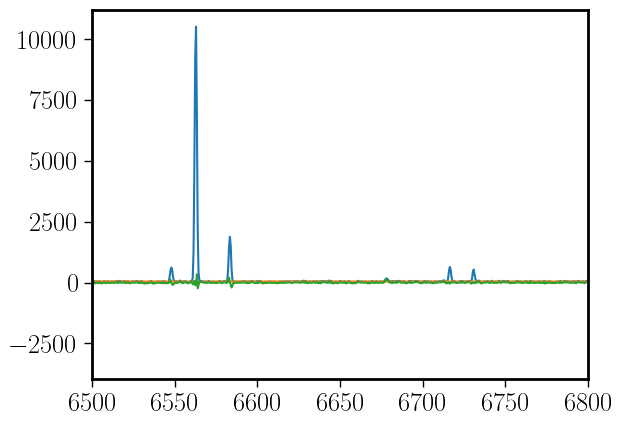

In [9]:
plt.plot(wave,hdu[0].data[0,100,:])
plt.plot(wave,hdu[0].data[1,100,:])
plt.plot(wave,hdu[0].data[4,100,:])
plt.xlim(6500,6800)

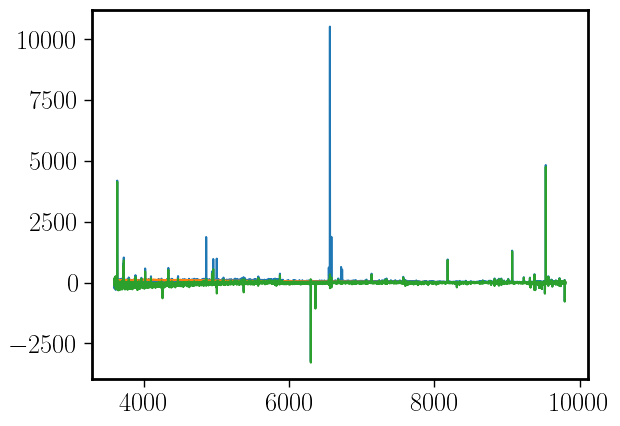

In [10]:
plt.plot(wave,hdu[0].data[0,100,:])
plt.plot(wave,hdu[0].data[1,100,:])
plt.plot(wave,hdu[0].data[4,100,:])


In [11]:
i_spec=100
org_spec = hdu[0].data[0,i_spec,:]
mod_spec = hdu[0].data[1,i_spec,:]
res_spec = hdu[0].data[4,i_spec,:]

In [12]:
cmd_args=(f'{label}',f'{label}', f'{config_yaml}')

parser = argparse.ArgumentParser(
    description="lvm-dap-yaml LVM_FILE OUTPUT_LABEL CONFIG.YAML"
)
parser.add_argument(
    "lvm_file", metavar="lvm_file",
    help="input LVM spectrum to fit"
)

parser.add_argument(
    "label",
    help="string to label the current run"
)

parser.add_argument(
    "config_yaml",
    help="config_yaml with the fitting parameters"
)
parser.add_argument(
    "-d", "--debug",
    help="debugging mode. Defaults to false.",
    action="store_true"
)

args = parser.parse_args(cmd_args)

with open(args.config_yaml, 'r') as yaml_file:
    dap_config_args = yaml.safe_load(yaml_file)
print(dap_config_args)

dict_param={}
for k, v in dap_config_args.items():
    if(isinstance(v, str)):
        v=v.replace("..",dap_config_args['lvmdap_dir'])
        dict_param[k]=v
    parser.add_argument(
        '--' + k, default=v
    )

parser.add_argument(
    "--flux-scale", metavar=("min","max"), type=np.float, nargs=2,
    help="scale of the flux in the input spectrum",
    default=[-1, +1]
)

parser.add_argument(
    "--plot", type=np.int,
    help="whether to plot (1) or not (0, default) the fitting procedure. If 2, a plot of the result is store in a %%file without display on screen",
    default=0
)





args = parser.parse_args(cmd_args)

#print(args)

{'output_path': '/disk-a/sanchez/LVM/LVM/ver_231113/input_sim/', 'lvmdap_dir': '/home/sanchez/sda2/code/python/lvmdap', 'rsp-file': '/disk-a/sanchez/LVM/LVM/templates/stellar-basis-spectra-100.fits.gz', 'sigma-inst': 1, 'rsp-nl-file': '/disk-a/sanchez/LVM/LVM/templates/stellar-basis-spectra-5.fits.gz', 'input-fmt': 'rss', 'redshift': [0.0, 0.0001, -0.0003, 0.0003], 'sigma': [1, 10, 1, 70], 'AV': [0, 0.3, 0.0, 1.5], 'emission-lines-file': '../_legacy/emission_lines_strong.LVM', 'emission-lines-file-long': '../_legacy/emission_lines_strong.LVM', 'w-range': [3800, 7000], 'mask-file': '../_legacy/mask_bands_LVM.txt', 'config-file': '../_legacy/auto_ssp_LVM.config', 'clear_outputs': True, 'w-range-nl': [3800, 4000], 'bin-nl': 3, 'bin-AV': 50, 'mask_file': 'none', 'ignore_gas': False, 'single-gas-fit': True, 'sigma-gas': 0.8, 'flux-scale-org': [-1, 1], 'single_rsp': False, 'do_plots': 1, 'only_integrated': False, 'out_plot_format': 'pdf', 'SN_CUT': 20, 'sky_hack': True, 'auto_redshift': True

/tmp/ipykernel_208046/424892247.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "--flux-scale", metavar=("min","max"), type=np.float, nargs=2,
/tmp/ipykernel_208046/424892247.py:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depr

In [13]:
print(args)

Namespace(lvm_file='sim_5', label='sim_5', config_yaml='lvm-dap_100.yaml', debug=False, output_path='/disk-a/sanchez/LVM/LVM/ver_231113/input_sim/', lvmdap_dir='/home/sanchez/sda2/code/python/lvmdap', rsp_file='/disk-a/sanchez/LVM/LVM/templates/stellar-basis-spectra-100.fits.gz', sigma_inst=1, rsp_nl_file='/disk-a/sanchez/LVM/LVM/templates/stellar-basis-spectra-5.fits.gz', input_fmt='rss', redshift=[0.0, 0.0001, -0.0003, 0.0003], sigma=[1, 10, 1, 70], AV=[0, 0.3, 0.0, 1.5], emission_lines_file='/home/sanchez/sda2/code/python/lvmdap/_legacy/emission_lines_strong.LVM', emission_lines_file_long='/home/sanchez/sda2/code/python/lvmdap/_legacy/emission_lines_strong.LVM', w_range=[3800, 7000], mask_file='/home/sanchez/sda2/code/python/lvmdap/_legacy/mask_bands_LVM.txt', config_file='/home/sanchez/sda2/code/python/lvmdap/_legacy/auto_ssp_LVM.config', clear_outputs=True, w_range_nl=[3800, 4000], bin_nl=3, bin_AV=50, ignore_gas=False, single_gas_fit=True, sigma_gas=0.8, flux_scale_org=[-1, 1], s

In [14]:

print('**** adopted arguments****')
a_name=[]
a_value=[]
for arg_name, arg_value in vars(args).items():
    a_name.append(arg_name)
    a_value.append(str(arg_value))
    
try:
    ny_range=args.ny_range
except:
    ny_range=None
    
try:
    nx_range=args.nx_range
except:
    nx_range=None

        
try:
    out_plot_format=args.out_plot_format
except:
    out_plot_format="pdf"        

try:
    only_integrated=args.only_integrated
except:
    only_integrated=False

try:
    sky_hack=args.sky_hack
except:
    sky_hack=False

try:
    auto_redshift=args.auto_redshift
except:
    auto_redshift=False

try:
    dump_model=args.dump_model
except:
    dump_model=False


try:
    SN_CUT=args.SN_CUT
except:
    SN_CUT=3

    
# OUTPUT NAMES ---------------------------------------------------------------------------------
out_file_elines = os.path.join(args.output_path, f"elines_{args.label}")
out_file_single = os.path.join(args.output_path, f"single_{args.label}")
out_file_coeffs = os.path.join(args.output_path, f"coeffs_{args.label}")
out_file_fit = os.path.join(args.output_path, f"sim_{args.label}.fits")
out_file_ps = os.path.join(args.output_path, args.label)
if args.clear_outputs:
        clean_preview_results_files(out_file_ps, out_file_elines, out_file_single, out_file_coeffs, out_file_fit)
seed = print_time(print_seed=False, get_time_only=True)

**** adopted arguments****


In [15]:
print(out_file_ps)

/disk-a/sanchez/LVM/LVM/ver_231113/input_sim/sim_5


In [ ]:
#
# Main Loop
#
for i_sim in np.arange(n_sim):
    random_map=np.random.normal(0,1.0,size=(hdu[0].data.shape[1],hdu[0].data.shape[2]))
    err_map=random_map*hdu[0].data[4,:,:]
    random_index=hdu[0].data.shape[1]*np.random.rand(hdu[0].data.shape[2])
    random_index=random_index.astype(int)
    err_spec=0.0*res_spec
    err_spec_t=0.0*res_spec
    for i in np.arange(hdu[0].data.shape[2]):
        err_spec[i]=err_map[random_index[i],i]
        err_spec_t[i]=hdu[0].data[4,:,:][random_index[i],i]
    #plt.plot(err_spec)
    wl__w, f__w, ef__w = wave, org_spec, res_spec
    out_file=args.output_path+'/sim_junk.fits'
    config_file=args.config_file
    rsp_hdu=fits.open(args.rsp_file)
    n_coeffs=rsp_hdu[0].header['NAXIS2']
    coeffs_random=np.random.rand(n_coeffs)
    coeffs_select=np.zeros(n_coeffs)
    choice=np.random.choice(rsp_hdu[0].header['NAXIS2'], n_st)
    coeffs_select[choice]=coeffs_random[choice]
    coeffs_input=coeffs_select/np.sum(coeffs_select)
    print(coeffs_input,sum(coeffs_input))
    model_spectra = []
    
    if (i_sim==0):
        SPS_master=None
        
    _, SPS = model_rsp_elines_single_main(
        wl__w, f__w, ef__w, args.rsp_file,  config_file, out_file, ssp_nl_fit_file=args.rsp_file,
        w_min=args.w_range[0], w_max=args.w_range[1], nl_w_min=args.w_range_nl[0],
        nl_w_max=args.w_range_nl[1], mask_list=args.mask_file,
        min=args.flux_scale[0], max=args.flux_scale[1], elines_mask_file=args.emission_lines_file,
        fit_gas=not args.ignore_gas, 
        input_redshift=args.redshift[0], delta_redshift=args.redshift[1], 
        min_redshift=args.redshift[2], max_redshift=args.redshift[3],
        input_sigma=args.sigma[0], delta_sigma=args.sigma[1], min_sigma=args.sigma[2], max_sigma=args.sigma[3],
        input_AV=args.AV[0], delta_AV=args.AV[1], min_AV=args.AV[2], max_AV=args.AV[3],
        sigma_inst=args.sigma_inst, plot=args.plot, sps_class=StellarSynthesis,
        coeffs_input=coeffs_input, SPS_master=SPS_master
    )
    SPS_master=SPS
    i=i_sim
    SPS.output_gas_emission(filename=out_file_elines, spec_id=i)
    SPS.output_coeffs_MC(filename=out_file_coeffs, write_header=i==0)
    SPS.output(filename=out_file_ps, write_header=i==0, block_plot=False)
    hdu_org['FLUX'].data[i_sim,:]=SPS.spectra['model_min']
    hdu_org['ERROR'].data[i_sim,:]=err_spec_t
    #model_spectra.append(SPS.output_spectra_list)
    print(f'### **** {i_sim}/{n_sim} *****')

hdu_org.writeto(out_file_fit,overwrite=True)

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.034  0.1444 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1972 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0395 0.     0.
 0.     0.     0.145  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0193 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.171  0.1709 0.     0.     0.     0.     0.0786] 0.9999999999999999
-> median error in flux = -10.6046
-> median error in flux = -10.6046
-> median raw flux = 29.1265 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5455.0, 5545.0]
Signal-to-Noise inside normalization window = 2.330075251195778
-> MED_FLUX: 29.126529693603516 +- 192.175341

[0.     0.     0.     0.0435 0.     0.067  0.     0.     0.     0.     0.0235 0.     0.     0.     0.     0.     0.1124 0.     0.     0.1252 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1833 0.     0.     0.1113 0.     0.0966 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1186 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.1187 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ] 1.0
-> median error in flux = -10.6046
-> median raw flux = 29.1265 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5455.0, 5545.0]
Signal-to-Noise inside normalization window = 2.3063151717795396
-> MED_FLUX: 29.126529693603516 +- 192.175341056517 SN:2.3063151717795396
- Redshift: 0.000000

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.095  0.     0.1573 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0896 0.     0.     0.     0.1013 0.     0.     0.     0.     0.0822 0.     0.     0.     0.     0.     0.     0.1694 0.
 0.     0.     0.     0.     0.0414 0.     0.     0.     0.     0.     0.     0.     0.     0.0755 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.1883 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ] 0.9999999999999998
-> median error in flux = -10.6046
-> median raw flux = 29.1265 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5455.0, 5545.0]
Signal-to-Noise inside normalization window = 2.306469366519589
-> MED_FLUX: 29.126529693603516 +- 192.175341056517 SN:2.306469366519589
- Redsh

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0681 0.     0.     0.     0.     0.     0.     0.0261 0.     0.     0.     0.     0.171  0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0791 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1622 0.     0.     0.1235 0.     0.     0.     0.     0.005  0.1523 0.     0.     0.     0.     0.     0.
 0.072  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1406 0.    ] 1.0000000000000002
-> median error in flux = -10.6046
-> median raw flux = 29.1265 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5455.0, 5545.0]
Signal-to-Noise inside normalization window = 2.329709802934808
-> MED_FLUX: 29.126529693603516 +- 192.175341056517 SN:2.329709802934808
- Redsh

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0845 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.1877 0.     0.     0.     0.     0.     0.     0.1682 0.     0.0723 0.     0.     0.     0.     0.035  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.1614 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0263 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.0672 0.     0.     0.     0.     0.     0.     0.1976 0.     0.     0.     0.     0.     0.    ] 1.0
-> median error in flux = -10.6046
-> median raw flux = 29.1265 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5455.0, 5545.0]
Signal-to-Noise inside normalization window = 2.3295601032782076
-> MED_FLUX: 29.126529693603516 +- 192.175341056517 SN:2.3295601032782076
- Redshift: 0.000000

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0567 0.     0.1259 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.097  0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.1079 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1388 0.     0.     0.1473 0.0636 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.1103 0.     0.     0.     0.     0.1525 0.     0.     0.    ] 1.0
-> median error in flux = -10.6046
-> median raw flux = 29.1265 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5455.0, 5545.0]
Signal-to-Noise inside normalization window = 2.3297800090430227
-> MED_FLUX: 29.126529693603516 +- 192.175341056517 SN:2.3297800090430227
- Redshift: 0.000000

[0.     0.     0.     0.     0.     0.     0.1033 0.219  0.     0.     0.     0.1781 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0352 0.     0.     0.     0.     0.     0.     0.     0.0421 0.     0.     0.     0.     0.0709 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.0636 0.     0.0542 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0213 0.
 0.     0.     0.     0.2124 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ] 1.0000000000000002
-> median error in flux = -10.6046
-> median raw flux = 29.1265 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5455.0, 5545.0]
Signal-to-Noise inside normalization window = 2.3065566690748773
-> MED_FLUX: 29.126529693603516 +- 192.175341056517 SN:2.3065566690748773
- Red

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1561 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1322 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1255 0.     0.
 0.     0.     0.0314 0.     0.     0.1164 0.     0.     0.     0.     0.     0.     0.     0.0873 0.0355 0.     0.     0.     0.     0.     0.     0.143  0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.1484 0.     0.     0.     0.     0.     0.0242 0.     0.     0.     0.    ] 0.9999999999999998
-> median error in flux = -10.6046
-> median raw flux = 29.1265 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5455.0, 5545.0]
Signal-to-Noise inside normalization window = 2.306168280869267
-> MED_FLUX: 29.126529693603516 +- 192.175341056517 SN:2.306168280869267
- Redsh

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1308 0.     0.     0.1062 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.1216 0.     0.     0.     0.1058 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.12   0.     0.1285 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.1142 0.     0.0336 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1262 0.
 0.     0.     0.0131 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ] 1.0
-> median error in flux = -10.6046
-> median raw flux = 29.1265 - Warning: no cut (CUT_MEDIAN_FLUX = 0)


In [164]:


#
# SINGLE SIM
#

In [139]:
wl__w, f__w, ef__w = wave, org_spec, res_spec
out_file=args.output_path+'/sim_junk.fits'
config_file=args.config_file
rsp_hdu=fits.open(args.rsp_file)
n_coeffs=rsp_hdu[0].header['NAXIS2']
coeffs_random=np.random.rand(n_coeffs)
coeffs_select=np.zeros(n_coeffs)
choice=np.random.choice(rsp_hdu[0].header['NAXIS2'], n_st)
coeffs_select[choice]=coeffs_random[choice]
coeffs_input=coeffs_select/np.sum(coeffs_select)
print(coeffs_input,sum(coeffs_input))
model_spectra = []

#print(args.rsp_file)

[0.     0.     0.1637 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.2158 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1858 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.2024 0.     0.     0.     0.2322 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ] 1.0


In [140]:
_, SPS = model_rsp_elines_single_main(
    wl__w, f__w, ef__w, args.rsp_file,  config_file, out_file, ssp_nl_fit_file=args.rsp_file,
    w_min=args.w_range[0], w_max=args.w_range[1], nl_w_min=args.w_range_nl[0],
    nl_w_max=args.w_range_nl[1], mask_list=args.mask_file,
    min=args.flux_scale[0], max=args.flux_scale[1], elines_mask_file=args.emission_lines_file,
    fit_gas=not args.ignore_gas, 
    input_redshift=args.redshift[0], delta_redshift=args.redshift[1], 
    min_redshift=args.redshift[2], max_redshift=args.redshift[3],
    input_sigma=args.sigma[0], delta_sigma=args.sigma[1], min_sigma=args.sigma[2], max_sigma=args.sigma[3],
    input_AV=args.AV[0], delta_AV=args.AV[1], min_AV=args.AV[2], max_AV=args.AV[3],
    sigma_inst=args.sigma_inst, plot=args.plot, sps_class=StellarSynthesis,
    coeffs_input=coeffs_input
)
i=0
SPS.output_gas_emission(filename=out_file_elines, spec_id=i)
SPS.output_coeffs_MC(filename=out_file_coeffs, write_header=i==0)
print(f'Teff test = {SPS.teff_min}')
SPS.output(filename=out_file_ps, write_header=i==0, block_plot=False)
model_spectra.append(SPS.output_spectra_list)

-> median error in flux = -10.6046
-> median error in flux = -10.6046
-> median raw flux = 29.1265 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5455.0, 5545.0]
Signal-to-Noise inside normalization window = 2.330254183371446
-> MED_FLUX: 29.126529693603516 +- 192.175341056517 SN:2.330254183371446
- Redshift: 0.00000000 +- 0.00000000
- Sigma:    1.00000000 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
model_min_shape:  (12401,)
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
4340-4340 wavelength range: Saving 1 EML system to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
4101-4101 wavelength range: Saving 1 EML system to file /disk-a/sanchez/LVM/LVM/ver_231113

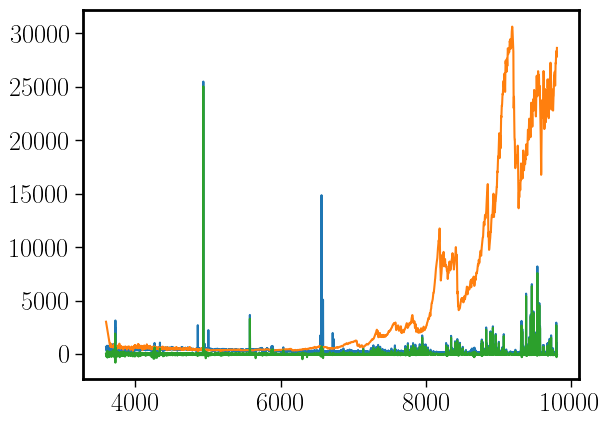

In [112]:
plt.plot(wave,org_spec)
plt.plot(wave,SPS.spectra['model_min'])
plt.plot(wave,ef__w)

-> median error in flux = 0.0000
-> median error in flux = 0.0000
-> median raw flux = 280.8842 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5455.0, 5545.0]
Signal-to-Noise inside normalization window = 11.293192983425278
-> MED_FLUX: 280.88421630859375 +- 454.0773235204956 SN:11.293192983425278
- Redshift: 0.00000000 +- 0.00000000
- Sigma:    1.00000000 +- 0.00000000
- Av:    1.00000000 +- 0.00000000
model_min_shape:  (12401,)
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
4340-4340 wavelength range: Saving 1 EML system to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap/elines_junk
4101-4101 wavelength range: Saving 1 EML system to file /disk-a/sanchez/LVM/LVM/ver_231113

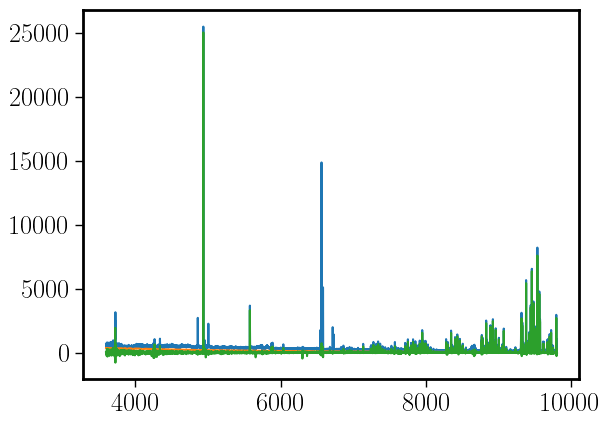

In [113]:
coeffs_now=0.0*coeffs_input
coeffs_now[0]=1

args.AV[0]=1
_, SPS = model_rsp_elines_single_main(
    wl__w, f__w, ef__w, args.rsp_file,  config_file, out_file, ssp_nl_fit_file=args.rsp_file,
    w_min=args.w_range[0], w_max=args.w_range[1], nl_w_min=args.w_range_nl[0],
    nl_w_max=args.w_range_nl[1], mask_list=args.mask_file,
    min=args.flux_scale[0], max=args.flux_scale[1], elines_mask_file=args.emission_lines_file,
    fit_gas=not args.ignore_gas, 
    input_redshift=args.redshift[0], delta_redshift=args.redshift[1], 
    min_redshift=args.redshift[2], max_redshift=args.redshift[3],
    input_sigma=args.sigma[0], delta_sigma=args.sigma[1], min_sigma=args.sigma[2], max_sigma=args.sigma[3],
    input_AV=args.AV[0], delta_AV=args.AV[1], min_AV=args.AV[2], max_AV=args.AV[3],
    sigma_inst=args.sigma_inst, plot=args.plot, sps_class=StellarSynthesis,
    coeffs_input=coeffs_now
)
i=0
SPS.output_gas_emission(filename=out_file_elines, spec_id=i)
SPS.output_coeffs_MC(filename=out_file_coeffs, write_header=i==0)
print(f'Teff test = {SPS.teff_min}')
SPS.output(filename=out_file_ps, write_header=i==0, block_plot=False)
model_spectra.append(SPS.output_spectra_list)



plt.plot(wave,org_spec)
plt.plot(wave,SPS.spectra['model_min'])
plt.plot(wave,ef__w)


In [114]:
model_spectra = np.array(model_spectra).transpose(1, 0, 2)
dump_rss_output(out_file_fit=out_file_fit, wavelength=wl__w, model_spectra=model_spectra)

array([[[   687.652 ,    653.159 ,    590.4202, ...,    959.7869,    981.6826,   1012.1271],
        [   687.652 ,    653.159 ,    590.4202, ...,    959.7869,    981.6826,   1012.1271],
        [   687.652 ,    653.159 ,    590.4202, ...,    959.7869,    981.6826,   1012.1271]],

       [[  3050.9247,   3029.6598,   3008.395 , ...,  28412.449 ,  28522.0301,  28638.6201],
        [  3034.2536,   3013.1549,   2992.0561, ...,  28413.0817,  28522.5221,  28639.3124],
        [   352.9948,    352.8291,    352.6632, ...,     27.5129,     27.4788,     27.4941]],

       [[  3050.9247,   3029.6598,   3008.395 , ...,  28412.449 ,  28522.0301,  28638.6201],
        [  3034.2536,   3013.1549,   2992.0561, ...,  28413.0817,  28522.5221,  28639.3124],
        [   352.9948,    352.8291,    352.6632, ...,     27.5129,     27.4788,     27.4941]],

       [[   687.652 ,    653.159 ,    590.4202, ...,    959.7869,    981.6826,   1012.1271],
        [   687.652 ,    653.159 ,    590.4202, ...,    959.7869